In [13]:
## Creating shp file with new F, G, H labels to override model predictions 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os, sys
import pickle
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
path_dict = loadpaths.loadpaths()

### Test how to merge:

In [6]:
pol1 = shp.geometry.Polygon([(0,0), (0,1), (1,1), (1,0)])
pol2 = shp.geometry.Polygon([(2,0), (2,1), (2.5,1), (2.5,0)])
pol3 = shp.geometry.Polygon([(0.5,0.5), (0.5,1.5), (1.5,1.5), (1.5,0.5)])
pol4 = shp.geometry.Polygon([(0,2), (0,4), (1,3), (1,2)])

df1 = gpd.GeoDataFrame({'geometry': [pol1, pol2], 'lab': ['A', 'A']})
df2 = gpd.GeoDataFrame({'geometry': [pol3, pol4], 'lab': ['C', 'C']})
df3 = gpd.GeoDataFrame({'geometry': [pol1, pol2, pol3, pol4]})

  lab                                           geometry
0   A  POLYGON ((0.00000 0.00000, 0.00000 1.00000, 0....
1   A  POLYGON ((2.00000 0.00000, 2.00000 1.00000, 2....
2   C  POLYGON ((1.00000 0.50000, 0.50000 0.50000, 0....
3   C  POLYGON ((0.00000 2.00000, 0.00000 4.00000, 1....


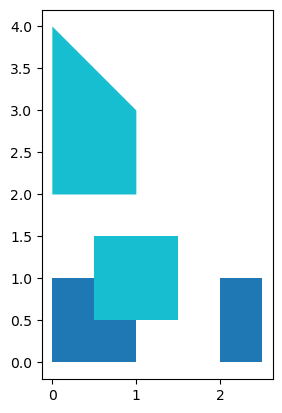

In [9]:
df_unique_1 = gpd.overlay(df1, df2, how='difference')  # Get df1 polygons that are not in df2
df_unique_2 = gpd.overlay(df2, df1, how='difference')  # Get df2 polygons that are not in df1
df_overlap = gpd.overlay(df1, df2, how='intersection')  # Get overlap between df1 and df2
df_overlap['lab'] = df_overlap['lab_2']  # choose label that is to be used for overlap
df_overlap = df_overlap.drop(['lab_1', 'lab_2'], axis=1)

df_new = gpd.GeoDataFrame(pd.concat([df_unique_1, df_unique_2, df_overlap], ignore_index=True))  # Concatenate all polygons
df_new = df_new.dissolve(by='lab', as_index=False)  # Dissolve polygons with same label
df_new = df_new.explode().reset_index(drop=True)
print(df_new)
df_new.plot(column='lab')


With this, the iterative plan for multi-layered data is:
- Define ranking of layers. Layer-1 is to be on top, then layer-2 etc. 
- Merge layer 1 and 2, and make sure 1 is on top. 
- Then merge layer-1/2 and layer-3, and make sure 1/2 is on top. 
- Continue till all layers are done. 

## Create layer for overriding model predictions:

In [16]:
## Load OS data:

dir_gpkg = '/home/tplas/data/gis/os_mastermap/'

dict_gpkg_file_names = {'roads': 'trn_fts_roadtrackorpath.gpkg',
                        'buildings': 'bld_fts_buildingpart.gpkg',
                        'sites': 'lus_fts_site.gpkg',
                        'structures': 'str_fts_structure.gpkg',
                        'railways': 'trn_fts_rail.gpkg',
                        'water': 'wtr_fts_water.gpkg',
                        'land': 'lnd_fts_land.gpkg'}  # different OS layers

dict_gdfs = {}
dict_unique_descriptions = {}

for key, value in dict_gpkg_file_names.items():
    path_layer = os.path.join(dir_gpkg, value)
    dict_gdfs[key] = gpd.read_file(path_layer)
    dict_unique_descriptions[key] = dict_gdfs[key]['description'].unique()

    ## Assert all geometry types are polygons
    set_unique_geom_types = set([type(x) for x in dict_gdfs[key]['geometry']])
    for geom_type in set_unique_geom_types:
        assert geom_type in [shp.geometry.polygon.Polygon, shp.geometry.multipolygon.MultiPolygon], f'Unexpected geometry type {geom_type} for {key}'

## Load PD outline:
pol_pd_outline = lca.load_pols(path_dict['pd_outline'])
pol_pd_outline

,Year,MI_PRINX,geometry
0,2015,2,"POLYGON ((432454.300 367391.315, 432454.193 36..."


In [38]:
## Create mapping dict template (from OS description to LC label)

os_to_lc_mapping = {key: {} for key in dict_gdfs.keys()}  # separate dict for each OS layer
min_size_dict = {key: None for key in dict_gdfs.keys()}

## Roads:
road_exceptions = ['Cycle Way', 'Path', 'Path And Steps', 'Track']  # all too minor to be considered transport routes
assert (np.isin(road_exceptions, dict_unique_descriptions['roads'])).all(), 'Road exceptions not found in OS data'
for descr in dict_unique_descriptions['roads']:
    if descr not in road_exceptions:
        os_to_lc_mapping['roads'][descr] = 'H1b'

# ## Buildings:
# for descr in dict_unique_descriptions['buildings']:
#     os_to_lc_mapping['buildings'][descr] = 'H1a'
## Better to use site layer .. ? [Private Residential Site]

## Sites:
other_isol_dev_list = ['Fish Farm']
skip_dev_list = ['Amenity And Open Space Site', 'Mine', 'Outdoor Activity Centre']
assert (np.isin(skip_dev_list, dict_unique_descriptions['sites'])).all(), 'Skip development exceptions not found in OS data'
assert (np.isin(other_isol_dev_list, dict_unique_descriptions['sites'])).all(), 'Other isolated development exceptions not found in OS data'
for descr in dict_unique_descriptions['sites']:
    if descr == 'Farm Site':
        os_to_lc_mapping['sites'][descr] = 'H3a'
    elif descr in other_isol_dev_list:
        os_to_lc_mapping['sites'][descr] = 'H3b' 
    elif descr == 'Quarry':
        os_to_lc_mapping['sites'][descr] = 'H2a'  # some false positives in here! 
    elif descr in ['Rail Freight Transport' 'Rail Maintenance Site' 'Railway Station']:
        os_to_lc_mapping['sites'][descr] = 'H1b'
    elif descr in skip_dev_list:
        continue
    else:
        os_to_lc_mapping['sites'][descr] = 'H1a'

## Structures 
## Think we can ignore these; mostly covered by sites for urban staff anyway. otherwise lots of tiny structures that are not relevant.

## Railways:
for descr in dict_unique_descriptions['railways']:
    os_to_lc_mapping['railways'][descr] = 'H1b'

## Water:
water_exceptions = ['Collects', 'Drain', 'Leat', 'Mill Leat', 'Open Tank Reservoir', 'Open Water Tank', 
                    'Overflow', 'Paddling Pool', 'Reed Bed For Waste Water', 'Settling Pond', 'Spreads',
                    'Spring', 'Swimming Pool', 'Watercourse', 'Waterfall']
assert (np.isin(water_exceptions, dict_unique_descriptions['water'])).all(), 'Water exceptions not found in OS data'
for descr in dict_unique_descriptions['water']:
    os_to_lc_mapping['water'][descr] = 'F2'
## Maybe add minimum area threshold for water? 
min_size_dict['water'] = 100

## Land:
rock_list = ['Boulders Or Rock']
urban_land_list = ['Made Surface']
assert (np.isin(urban_land_list, dict_unique_descriptions['land'])).all(), 'Urban land exceptions not found in OS data'
assert (np.isin(rock_list, dict_unique_descriptions['land'])).all(), 'Rock exceptions not found in OS data'
for descr in dict_unique_descriptions['land']:
    if descr in rock_list:
        os_to_lc_mapping['land'][descr] = 'G2'
    elif descr in urban_land_list:
        os_to_lc_mapping['land'][descr] = 'H3b'




In [39]:
get_intersection_with_pd_outline = False 

dict_layers = {} 
if get_intersection_with_pd_outline:
    print('WARNING: getting intersection with PD will take considerably more time. (Minutes instead of seconds)')
## Loop through different layers & reduce to only features and attrs needed.
for it, (key, gdf_layer) in enumerate(dict_gdfs.items()):
    inds_use = gdf_layer['description'].isin(os_to_lc_mapping[key].keys())  # only use features with a mapping
    print(f'Using {np.sum(inds_use)}/{len(gdf_layer)} features from {key} layer')
    tmp_layer = gdf_layer.loc[inds_use, :].copy()
    
    if min_size_dict[key] is not None:  # apply area threshold if specified
        tmp_layer = tmp_layer.loc[tmp_layer['geometry'].area > min_size_dict[key], :]
        print(f'    Using {len(tmp_layer)} features from {key} layer after area thresholding')

    tmp_layer['lc_label'] = tmp_layer['description'].map(os_to_lc_mapping[key]) # add LC label
    
    tmp_layer = tmp_layer.drop(columns=[x for x in list(tmp_layer.columns) if x not in ['geometry', 'lc_label']])  # remove all columns that aren't relevant
    tmp_layer = tmp_layer.explode().reset_index(drop=True)  # explode multi-polygons into separate polygons
    if get_intersection_with_pd_outline:
        tmp_layer = gpd.overlay(tmp_layer, pol_pd_outline, how='intersection')  # get intersection with PD outline
    dict_layers[key] = tmp_layer.copy()    

    

Using 24745/34716 features from roads layer
Using 0/56423 features from buildings layer
Using 19704/19729 features from sites layer
Using 0/3089 features from structures layer
Using 328/328 features from railways layer
Using 6943/6943 features from water layer
    Using 3682 features from water layer after area thresholding
Using 19968/180798 features from land layer


In [40]:
dissolve_polygons = False

ranking_keys = ['water', 'sites', 'railways','roads', 'land']
n_keys = len(ranking_keys)
df_new = None 
if dissolve_polygons:
    print('WARNING: dissolving polygons takes considerably more time (hours instead of minutes).')
for i_rank in range(n_keys - 1):
    key_1 = ranking_keys[i_rank]
    key_2 = ranking_keys[i_rank + 1]

    if df_new is None:
        print(f'Overlaying {key_1} and {key_2} layers')
        df1 = dict_layers[key_1]
    else:
        print(f'Overlaying {key_2} layer')
        df1 = df_new
    df2 = dict_layers[key_2]

    df_unique_1 = gpd.overlay(df1, df2, how='difference')  # Get df1 polygons that are not in df2
    df_unique_2 = gpd.overlay(df2, df1, how='difference')  # Get df2 polygons that are not in df1
    df_overlap = gpd.overlay(df1, df2, how='intersection')  # Get overlap between df1 and df2
    df_overlap['lc_label'] = df_overlap['lc_label_1']  # choose label that is to be used for overlap
    df_overlap = df_overlap.drop(['lc_label_1', 'lc_label_2'], axis=1)

    df_new = gpd.GeoDataFrame(pd.concat([df_unique_1, df_unique_2, df_overlap], ignore_index=True))  # Concatenate all polygons
    if dissolve_polygons:
        df_new = df_new.dissolve(by='lc_label', as_index=False)  # Dissolve polygons with same label
        df_new = df_new.explode().reset_index(drop=True)

Overlaying water and sites layers


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 545 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Overlaying railways layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 201 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Overlaying roads layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 23813 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Overlaying land layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 27079 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


In [41]:
df_new.to_file('tmp_fgh_layer/tmp_fgh_layer.shp')

In [53]:
for key, descr_list in dict_unique_descriptions.items():
    if key == 'land':
        print(key, len(descr_list))
        print(np.sort(descr_list))
        print('\n\n')

land 73
['Arable Or Grazing Land' 'Bare Earth Or Grass' 'Boulders Or Rock'
 'Boulders Or Rock And Heath Or Rough Grassland'
 'Boulders Or Rock And Heath Or Rough Grassland And Marsh'
 'Boulders Or Rock And Heath Or Rough Grassland And Scattered Coniferous Trees'
 'Boulders Or Rock And Heath Or Rough Grassland And Scattered Non-Coniferous Trees'
 'Boulders Or Rock And Heath Or Rough Grassland Or Marsh'
 'Boulders Or Rock And Scattered Mixed Trees'
 'Boulders Or Rock And Scattered Non-Coniferous Trees' 'Coniferous Trees'
 'Coniferous Trees And Scattered Boulders Or Scattered Rock'
 'Coniferous Trees And Scattered Boulders Or Scattered Rock And Scrub'
 'Coniferous Trees And Scrub' 'Construction Site' 'Gallops' 'Games Court'
 'Heath' 'Heath Or Rough Grassland' 'Heath Or Rough Grassland And Marsh'
 'Heath Or Rough Grassland And Marsh And Scattered Coniferous Trees'
 'Heath Or Rough Grassland And Marsh And Scattered Non-Coniferous Trees'
 'Heath Or Rough Grassland And Marsh And Scrub'
 'Heat